In [46]:
import numpy as np
np.seterr(all='raise')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

### Funciones de costo

In [2]:
class error_cuadrático_medio:
    @staticmethod
    def f(predicción, objetivo):
        return np.mean(np.linalg.norm(predicción - objetivo, axis=1, ord=2)**2) * 0.5
    
    @staticmethod
    def d(predicción, objetivo):
        return predicción - objetivo
    

class error_absoluto_medio:
    @staticmethod
    def f(predicción, objetivo):
        return np.mean(np.linalg.norm(predicción - objetivo, axis=1, ord=1))
    
    @staticmethod
    def d(predicción, objetivo):
        return np.sign(predicción - objetivo)


class entropía_cruzada:
    @staticmethod
    def f(predicción, objetivo):
        return -np.mean( np.log(np.sum(objetivo * predicción, axis=1)) )
    
    @staticmethod
    def d(predicción, objetivo):
        return predicción - objetivo

### Funciones de activación

In [47]:
def escalón():
    f = lambda x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
    d = lambda x: 1
    
    return f, d


def identidad():
    f = lambda x: x
    d = lambda x: 1
    
    return f, d


def relu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0, 1])

    return f, d


# leaky ReLU, la derivada para x <= 0 no es nula sino un valor pequeño
def lrelu():
    f = lambda x: np.maximum(0, x)
    d = lambda x: np.piecewise(x, [x <= 0, x > 0], [0.01, 1])

    return f, d


def logística():
    f = lambda x: 1 / (1 + np.exp(-x))
    d = lambda x: f(x) * (1 - f(x))

    return f, d


def tanh():
    f = np.tanh
    d = lambda x: 1 - f(x)**2
    
    return f, d


def softmax():
    def f(x):
        _x = x - np.max(x, axis=1, keepdims=True) # es para que no explote
        return np.exp(_x) / np.sum(np.exp(_x), axis=1, keepdims=True)
    
    def d(x):
        return 1.0 # implementada en la función de costo (entropía cruzada) por una cuestión de simplicidad
        
    return f, d

### Arduino

Control vivo de la tasa de aprendizaje con un potenciómetro.

In [ ]:
import serial
s = serial.Serial('/dev/ttyUSB0', 9600)

In [ ]:
import time

def arduino(s):
    global eta, señal
    señal = True
    
    while señal:
        eta = round(int(s.readline()) / 1023, 3)

In [ ]:
import threading

t = threading.Thread(target=arduino, args=(s,))
t.start()

In [ ]:
señal = False
s.close()

## Elementos de la red

Una **capa** se define en base a cierta cantidad de unidades con una función de activación.

En la **propagación** el parámetro `entrada` representa el valor de entrada a las unidades y el parámetro `salida`, el de salida. Cabe notar que a la salida se le agrega el bias de la capa. El bias es _virtual_, no está representado como unidad.

```
    entrada    función activación    salida
                                     | s0 | = 1 (BIAS)
    | e1 |                           | s1 |
    | e2 | --> f(entrada) ---------> | s2 |
    | e3 |                           | s3 |
```

Cuando consideramos la **retropropagación** del error, el sentido inverso utiliza los parámetros `error_entrada` y `error_salida` para los errores que *salen de y entran a* la capa, respectivamente.

```
    entrada     derivada activación  salida
                                     | es0 | = 1 (BIAS)
    | ee1 |                          | es1 |
    | ee2 | <- f'(entrada) ·         | es2 |
    | ee3 |          error_salida <- | es3 |
```

In [4]:
class Capa:
    
    def __init__(self, activación, unidades):
        self.función, self.derivada = activación()
        self.unidades = unidades
        self.feeds = []
        self.backs = []
        
        
    def propagar(self):
        Z = self.función(self.entrada)
        # (n_lote, dim_capa + 1) <- (n_lote, dim_capa)
        self.salida = np.insert(Z, 0, 1., axis=1) # agrega vector columna de bias

        for sinapsis in self.feeds: sinapsis.propagar()


    def retropropagar(self):
        # (n_lote, dim_capa) <- (n_lote, dim_capa + 1)
        E = np.delete(self.error_salida, 0, axis=1) # remueve vector columna de bias
        
        dZ = self.derivada(self.entrada)
        # (n_lote, dim_capa) <- (n_lote, dim_capa) * (n_lote, dim_capa) 
        self.error_entrada = E * dZ 
        
        for sinapsis in self.backs: sinapsis.retropropagar()
            
            
    def actualizar_pesos(self, eta, mu, _lambda):
        for sinapsis in self.feeds: sinapsis.actualizar_pesos(eta, mu, _lambda)
        
        
    def estado(self):
        return np.delete(self.salida, 0, axis=1) # remueve vector columna de bias
    
    
    def error(self, E):
        self.error_salida = np.insert(E, 0, 1., axis=1) # agregar vector columna de bias

Las capas se comunican mediante **sinapsis**. Una sinapsis tiene una capa de _origen_ y una de _destino_, a su vez guarda los pesos de las conexiones entre unidades.

Los elementos de la red están pensados para tratar a las muestas como *vectores filas*. En un arreglo bidimensional de varias muestras, cada fila es una muestra y las columnas del arreglo son los distintos atributos. En la bibliografía se suele observar otro camino: las muestras son *vectores columnas*; quizás sea más sencillo para hacer/interpretar cuentas. En la práctica, encontramos a los vectores filas más a tono con la forma de los conjuntos de datos (pensar en un archivo CSV o en una tabla de una base de datos).

```
    filas    = dim(origen) + 1 (BIAS)
    columnas = dim(destino)
    
    W =  | b00  b01 |  matriz de pesos de una sinapsis que conecta una capa de 3 unidades (origen) con otra de 2 (destino)
         | w10  w11 |  la primera fila corresponde a los pesos del bias
         | w20  w21 |
         | w30  w31 |
         
    Y =  | 1  a1  a2  a3 |  actividad de salida de la capa de origen, 2 muestras con 3 atributos y bias (primera columna)
         | 1  b1  b2  b3 |
         
    Z =  Y · W =  | a'1  a'2 |  la actividad de entrada a la capa de destino entonces se calcula
                  | b'1  b'2 |  como el producto interno entre la salida (Y) y los pesos (W)
```

In [5]:
class Sinapsis:
  
    def __init__(self, origen, destino):
        # capas
        self.origen  = origen
        self.destino = destino
        
        self.forma   = (origen.unidades + 1, destino.unidades)
        
        self.V_prev      = np.zeros(self.forma)
        self.V           = np.zeros(self.forma)
        self.delta_pesos = np.zeros(self.forma)
        self.pesos       = np.random.normal(scale=np.sqrt(2.0/self.forma[0]), size=self.forma)
        
        
    def propagar(self):
        # (n_lote, dim_destino) <- (n_lote, dim_origen + 1) . (dim_origen + 1, dim_destino)
        self.destino.entrada = np.dot(self.origen.salida, self.pesos)
    
    
    def retropropagar(self):
        # (n_lote, dim_origen + 1) <- (n_lote, dim_destino) . (dim_destino, dim_origen + 1) 
        self.origen.error_salida = np.dot(self.destino.error_entrada, self.pesos.T)
        
        n_lote = self.destino.error_entrada.shape[0]
        # (dim_origen + 1, dim_destino) <- (dim_origen + 1, n_lote) . (n_lote, dim_destino)
        self.delta_pesos = np.dot(self.origen.salida.T, self.destino.error_entrada) / n_lote # promedio de las contribuciones
                                                                                             # de cada muestra
                
    def actualizar_pesos(self, eta, mu, _lambda):
        """http://cs231n.github.io/neural-networks-3/
        
        Momento
        v = mu * v - learning_rate * dx    # integrate velocity
        x += v                             # integrate position

        Momento de Nesterov
        v_prev = v                         # back this up
        v = mu * v - learning_rate * dx    # velocity update stays the same
        x += -mu * v_prev + (1 + mu) * v   # position update changes form

        Recommended annealing schedules for mu: 0.5, 0.9, 0.95, 0.99
        """
        
        self.V_prev =  self.V
        self.V      =  mu * self.V - eta * (self.delta_pesos + _lambda * self.pesos)
        self.pesos += -mu * self.V_prev + (1 + mu) * self.V

El **perceptrón**.

In [15]:
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize
from sklearn.preprocessing   import LabelBinarizer


class Red(BaseEstimator):

    def __init__(self, activación=logística, inicialización=.01, capas_ocultas=(),
                 épocas=1000, tolerancia=1e-5, lote=10, costo=error_cuadrático_medio,
                 aprendizaje=.05, momento=.5, adaptación=0, 
                 early_stopping=False, regularización=0,
                 validación=False, graficar=False, chequeo=False):
        
        self.activación     = activación
        self.inicialización = inicialización
        self.capas_ocultas  = capas_ocultas
        
        self.épocas     = épocas
        self.tolerancia = tolerancia
        self.lote       = lote
        
        self.aprendizaje = aprendizaje
        self.momento     = momento
        self.adaptación  = adaptación
        self.regularización = regularización
        
        self.early_stopping = early_stopping
            
        self.validación = validación
        self.graficar = graficar
        
        self.chequeo = chequeo
        self.épsilon = 1e-4
        self.costo   = costo
        
    def lotes(X, y, n):
    if n < 1: n = len(X)
    
    for i in range(0, len(X), n):
        yield X[i:i+n], y[i:i+n]

        
def barajar(X, y):
    e = np.random.get_state()
    X = np.random.permutation(X)
    np.random.set_state(e)
    y = np.random.permutation(y)
    
    return X, y


def graficar(evolución_error, c='b'):
    p, = plt.plot(evolución_error, c=c)
    plt.yscale('log')
    plt.xlabel('épocas')
    plt.ylabel('error')
    return p


    def _inicializar(self, n_entradas, n_salidas):
        self.capas    = OrderedDict()
        self.sinapsis = OrderedDict()
        
        # instanciación de capas
        self.capas['entrada'] = Capa(identidad, n_entradas)
        
        for i, n_unidades in enumerate(self.capas_ocultas):
            id_capa = 'oculta_%s' % (i + 1)
            self.capas[id_capa] = Capa(self.activación, n_unidades)
        
        self.capas['salida'] = Capa(softmax, n_salidas)
        
        # se asume que la red es feed-forward
        ids_capas  = list(self.capas.keys())
        conexiones = [(capa_origen, capa_destino) for capa_origen, capa_destino in zip(ids_capas, ids_capas[1:])]
            
        # instanciación de sinapsis
        for (id_origen, id_destino) in conexiones:
            origen   = self.capas[id_origen]
            destino  = self.capas[id_destino]
            
            sinapsis = self.sinapsis[(id_origen, id_destino)] = Sinapsis(origen, destino)
            
            origen.feeds.append(sinapsis)
            destino.backs.append(sinapsis)        
    

    def fit(self, X, y):
        self.label_binarizer = LabelBinarizer()
        y = self.label_binarizer.fit_transform(y)
        global eta

        # asegurarse de que 'y' sea 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))
        
        n_entradas = X.shape[1]
        n_salidas  = y.shape[1]
        
        self._inicializar(n_entradas, n_salidas)
        
        self.evolución_error = []
        self.evolución_validación = []
        self.convergencia = False
        
        if self.validación:
            X, X_val, y, y_val = train_test_split(X, y, test_size=.2)

        if self.graficar:
            %matplotlib notebook
            fig = plt.figure()
            ax  = fig.add_subplot(111)
        
            plt.yscale('log')
            plt.xlabel('épocas')
            plt.ylabel('error')
            plt.ion()

                        
        for época in range(self.épocas):            
            eta = self.aprendizaje * np.exp(-self.adaptación * época) 
            
            _X, _y = barajar(X, y)
            
            for lote_X, lote_y in lotes(_X, _y, self.lote):
                self._aprender(lote_X, lote_y, eta, self.momento, self.regularización)
            
            error = self.costo.f(_y, self.predict(_X))
            self.evolución_error.append(error)
            
            if self.validación:
                error_validación = self.costo.f(y_val, self.predict(X_val))
                self.evolución_validación.append(error_validación)
                
            if self.graficar: #and época % 2 == 0:
                e = ax.plot(self.evolución_error, c='b')
                
                if self.validación:
                    v = ax.plot(self.evolución_validación, c='g')
    
                ax.set_xlim([época - 10, época])
                ax.set_ylim([1e-6, 10])
            
                #plt.legend([v, e], ['validación', 'entrenamiento'])
            
                ax.set_title('n = %s | µ = %s' % (eta, self.momento))
                fig.canvas.draw()
                
            if error <= self.tolerancia:
                self.convergencia = True
                break
        
        return self
       
                 
    def _aprender(self, X, y_objetivo, eta, mu, _lambda):
        self.capas['salida'].error(self.costo.d(self.predict(X), y_objetivo)) 
        
        for _, capa in reversed(self.capas.items()): capa.retropropagar()
        
        if self.chequeo: self._chequeo(X, y_objetivo)
        
        for _, capa in self.capas.items(): capa.actualizar_pesos(eta, mu, _lambda)

        
    def _chequeo(self, X, y_objetivo):
        índice_sinapsis = np.random.randint( len(self.sinapsis.values()) )
        sinapsis = list(self.sinapsis.values())[índice_sinapsis]
            
        unidad_origen  = np.random.randint(sinapsis.forma[0]) # filas
        unidad_destino = np.random.randint(sinapsis.forma[1]) # columnas
            
        peso_original  = sinapsis.pesos[unidad_origen][unidad_destino]
        
        sinapsis.pesos[unidad_origen][unidad_destino] = peso_original + self.épsilon
        error_más      = self.costo.f(self.predict(X), y_objetivo)
            
        sinapsis.pesos[unidad_origen][unidad_destino] = peso_original - self.épsilon
        error_menos    = self.costo.f(self.predict(X), y_objetivo)

        sinapsis.pesos[unidad_origen][unidad_destino] = peso_original
            
        g  = (error_más - error_menos) / (2 * self.épsilon)
        dw = sinapsis.delta_pesos[unidad_origen][unidad_destino]
        print(dw, '\t', g)
        
    
    def predict(self, X):
        self.capas['entrada'].entrada = X
        
        for _, capa in self.capas.items(): capa.propagar()
        
        return self.capas['salida'].estado()

    
class Clasificador(Red):
        
    def score(self, X, y):
        #return accuracy_score(y, binarize(self.predict(X), threshold=0.5))
        #return f1_score(y, binarize(self.predict(X), threshold=0.5))
        y_pred = self.label_binarizer.inverse_transform(self.predict(X))
        return accuracy_score(y_pred, y)

    
class Regresor(Red):
   
    def score(self, X, y):
        return -error_cuadrático_medio.f(self.predict(X), y)

## Pruebas

In [51]:
X = np.array([[1, 1],
              [1, 0],
              [0, 1],
              [0, 0]])

y = np.array([[1, 1, 0],
              [0, 1, 1],
              [0, 1, 1],
              [0, 0, 0]])

<IPython.core.display.Javascript object>


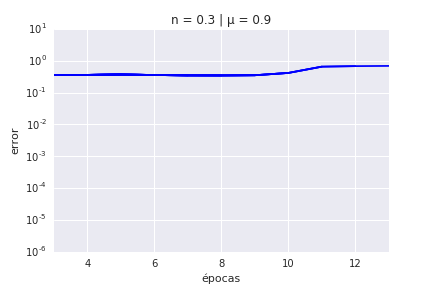

FloatingPointError: underflow encountered in multiply

In [56]:
rn = Clasificador(lote=2, capas_ocultas=(2,), activación=relu, graficar=True, épocas=50, aprendizaje=.3, momento=.9).fit(X, y)
#print('convergencia', rn.convergencia)
#graficar(rn.evolución_error)
#plt.savefig('error.png')

## Experimentos

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import LabelBinarizer
from sklearn.pipeline        import make_pipeline

tp1 = 'tp1_ej1_training.csv'
tp2 = 'tp1_ej2_training.csv'

X_tp1 = np.loadtxt(tp1, dtype='float', delimiter=',', usecols=range(1,10))
y_tp1 = np.loadtxt(tp1, dtype='str',   delimiter=',', usecols=(0,))

X_tp2 = np.loadtxt(tp2, delimiter=',', usecols=(0,1,2,3,4,5))
y_tp2 = np.loadtxt(tp2, delimiter=',', usecols=(6,7))

y_tp2[:,0] /= y_tp2[:,0].max()
y_tp2[:,1] /= y_tp2[:,1].max()

# transforma las etiquetas 'B' y 'M' a ceros y unos
binarizer = LabelBinarizer()
y_tp1 = binarizer.fit_transform(y_tp1)

# partición del conjunto de datos en conjuntos de entrenamiento (70%) y prueba (30%)
X1_train, X1_test, y1_train, y1_test = train_test_split(X_tp1, y_tp1, test_size=0.25, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tp2, y_tp2, test_size=0.25, random_state=42)

* capas
* unidades
* función de activación
* hiperparámetros adaptativos
* estocástico/batch/mini-batch
* eta / mu (incluyendo mu nulo)
* preprocesamiento
* early-stopping

estocástico + fit agresivo (eta, mu ~ 1) suele explotar

muchas unidades implica cuidar la inicialización de los pesos porque explotan

como los resultados van entre 0 y 1 se escogió logística y relu. relu no da buenos resultados. 

* función de activación softmax en la última capa
* derivada de softmax

* función de pérdida (cross entropy)
* derivada de la función de pérdida para el error

### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

estimador = make_pipeline(StandardScaler(), Clasificador())

grilla = {       
        'clasificador__activación': [logística, relu],
    'clasificador__inicialización': [(-.5,.5), (.01,.5)],
     'clasificador__capas_ocultas': [(10,), (14,6), (6,6), (12,6,3)],
              'clasificador__lote': [-1, 1, 10],
       'clasificador__aprendizaje': [.9, .5, .1, .01],
           'clasificador__momento': [.9, .5, .1, 0]
}

In [ ]:
np.seterr(all='raise')
clf = GridSearchCV(estimador, grilla, cv=3, n_jobs=3, error_score=0)
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_.score(X_test, y_test)

In [ ]:
%matplotlib inline
graficar(clf.best_estimator_.named_steps['clasificador'].evolución_error)
#plt.savefig('error_mejor_estimador.png')

In [ ]:
import pickle

with open('resultados_ej1.pickle', 'wb') as f:
    pickle.dump(clf.cv_results_, f)

### Ejercicio 1

* precisión promedio del 85%


In [ ]:
pipe = make_pipeline(StandardScaler(),
                     Clasificador(épocas=10000,
                                  tolerancia=1e-5,
                                  capas_ocultas=(9,6),
                                  graficar=True, validación=True, normalización=0.000001,
                                  adaptación=0, aprendizaje=.001, momento=.9,
                                  activación=relu, lote=5))
pipe.fit(X1_train, y1_train)

pipe.score(X1_test, y1_test)

### Ejercicio 2

In [ ]:
pipe = make_pipeline(StandardScaler(),
                     Regresor(épocas=500, chequeo=False,
                              capas_ocultas=(4,3), costo=error_absoluto_medio,
                              graficar=True, validación=True,
                              adaptación=0, aprendizaje=.0001, momento=0.7,
                              activación=relu, lote=5))

pipe.fit(X2_train, y2_train)

pipe.score(X2_test, y2_test)

### MNIST

In [36]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

mnist = fetch_mldata('MNIST original')
X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

<IPython.core.display.Javascript object>


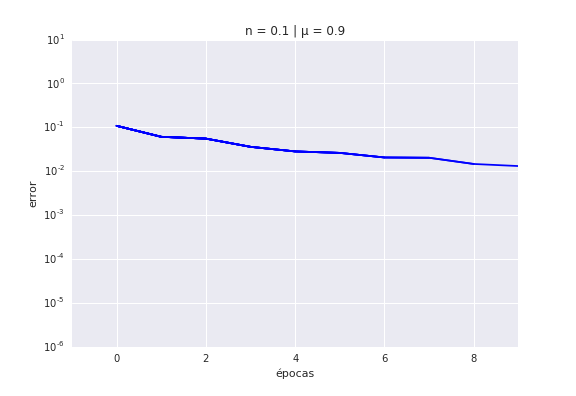

0.98050000000000004

In [44]:
r = Clasificador(épocas=10, lote=128, capas_ocultas=(256,), activación=relu, costo=entropía_cruzada,
                 aprendizaje=.1, momento=.9, regularización=.0001, graficar=True)

r.fit(X_train, y_train)
r.score(X_test, y_test)